## Define and train a custom Parametric Quantum Circuit

In [54]:
import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates, hamiltonians

from qiboml.models import pqc, encodings
from qiboml.optimizers.minimizers import ScipyMinimizer

from importlib import reload
reload(pqc)
reload(encodings)

qibo.set_backend("numpy")

[Qibo 0.2.6|INFO|2024-03-15 09:36:11]: Using numpy backend on /CPU:0


In [55]:
ndim = 2  # Number of dimensions
ndata = 50  # Number of data points

# Create the linspace
linspace_column = np.linspace(0, 1, ndata)

# Repeat the linspace for ndim columns and reshape
data = np.repeat(linspace_column[:, np.newaxis], ndim, axis=1)

# example data
print(data[3])

[0.06122449 0.06122449]


In [69]:
def target_function(data):
    labels = np.sum(np.sin(data)**2 - np.cos(4*data)**2, axis=1)
    labels = (labels - max(labels)) / (max(labels) - min(labels)) * 2 + 1
    return labels

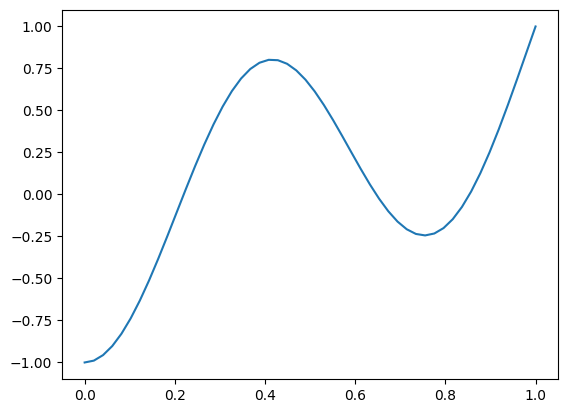

In [70]:
labels = target_function(data)

plt.plot(data[:,1], labels)
plt.show()

In [81]:
nqubits = 2
nlayers = 6

model = pqc.PQC(nqubits=nqubits)

for l in range(nlayers):
    for q in range(nqubits):
        model.add(gates.RY(q=q, theta=0))
        model.add(gates.RZ(q=q, theta=0))
    for q in range(0, nqubits-1, 1):
        model.add(gates.CNOT(q0=q, q1=q+1))
    model.add(gates.CNOT(q0=nqubits-1, q1=0))
model.add(gates.M(*range(nqubits)))

In [82]:
print(model.draw())

q0: ─RY─RZ─o─X─RY─RZ─o─X─RY─RZ─o─X─RY─RZ─o─X─RY─RZ─o─X─RY─RZ─o─X─M─
q1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─


In [84]:
# define the optimizer
opt = ScipyMinimizer(method="BFGS")

# define the loss function
def loss_function(predictions, labels):
    loss = np.sum( (predictions - labels)**2 ) / len(predictions)
    print(loss)
    return loss

# define the observable
obs = hamiltonians.Z(nqubits=nqubits)

# define the encoding strategy
# define the encoding circuit

def build_encoding_circuit(nqubits):
    """Simple example: one RX per gate."""
    encoder = Circuit(nqubits)
    for q in range(nqubits):
        encoder.add(gates.RX(q, 0))
    return encoder

def define_encoding_strategy(circuit, data):
    """Simple example: one data per rotation angle."""
    circuit.set_parameters(data)
    return circuit

encoding_circuit = encodings.EncodingCircuit(
    build_encoding_circuit(nqubits),
    define_encoding_strategy
)

In [85]:
model.setup(
    optimizer=opt,
    loss=loss_function,
    observable=obs,
    encoding_config=encoding_circuit
)

In [ ]:
model.set_parameters(np.random.randn(model.nparams))
print(model.parameters)
model.fit(input_data=data, output_data=labels )

In [91]:
predictions = model.predict_sample(data[10:])

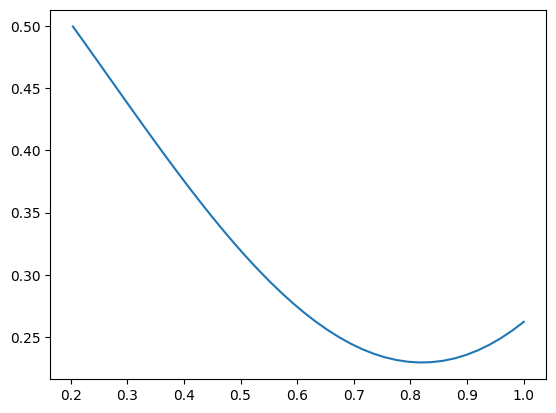

In [93]:
plt.plot(data[10:,0], predictions)